In [1]:
device="cuda:2"
import io,  torch,  PIL.Image, einops, math, datasets
import matplotlib.pyplot as plt, numpy as np
from IPython.display import HTML
from types import SimpleNamespace
from timm.optim import Mars
from fastprogress import progress_bar, master_bar
from torchvision.transforms.v2 import CenterCrop, RandomCrop, Resize
from torchvision.transforms.v2.functional import to_pil_image, pil_to_tensor
from autocodec.codec import AutoCodecND, latent_to_pil, pil_to_latent
from compressai.entropy_models import EntropyBottleneck

/home/dgj335/.local/lib/python3.10/site-packages/compressai/models/video/google.py:353: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  @amp.autocast(enabled=False)


In [2]:
dataset = datasets.load_dataset("danjacobellis/LSDIR")

Resolving data files:   0%|          | 0/195 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/195 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/178 [00:00<?, ?it/s]

In [3]:
config = SimpleNamespace()
config.F = 16
config.latent_dim = 48;
config.input_channels = 3
config.encoder_depth = 4
config.encoder_kernel_size = 1
config.decoder_depth = 8
config.lightweight_encode = True
config.lightweight_decode = False
config.freeze_encoder_after = 0.7
config.λ = 3e-2
config.lr_pow = 2
config.epochs = 30
config.progressive_sizes = [32*int(s) for s in 2**(np.linspace(2,3.4,config.epochs))];
config.batch_size = 16
config.max_lr = (64/config.batch_size)*1e-3
config.min_lr = config.max_lr / 1e3
config.num_workers = 32
config.total_steps = config.epochs * (dataset['train'].num_rows // config.batch_size)
config.checkpoint = False
print(f"(start res, end_res) {(config.progressive_sizes[0], config.progressive_sizes[-1])}")

(start res, end_res) (128, 320)


In [4]:
model = AutoCodecND(
    dim=2,
    input_channels=config.input_channels,
    J = int(np.log2(config.F)),
    latent_dim=config.latent_dim,
    encoder_depth = config.encoder_depth,
    encoder_kernel_size = config.encoder_kernel_size,
    decoder_depth = config.decoder_depth,
    lightweight_encode = config.lightweight_encode,
    lightweight_decode = config.lightweight_decode,
).to(device)

em = EntropyBottleneck(config.latent_dim).to(device)

if config.checkpoint:
    checkpoint = torch.load(config.checkpoint,weights_only=False)
    model.load_state_dict(checkpoint['state_dict'])

print(f"{sum(p.numel() for p in model.parameters())/1e6} M parameters")

optimizer = Mars(model.parameters(), lr=1.0, caution=True)
optimizer_em = Mars(em.parameters(), lr=10.0,  caution=True)

def rc_sched(i_step, config):
    t = i_step / config.total_steps
    return (config.max_lr - config.min_lr) * (1 - ((np.cos(np.pi*t))**(2*config.lr_pow))) + config.min_lr

schedule = torch.optim.lr_scheduler.LambdaLR(
    optimizer,
    lr_lambda=lambda i_step: rc_sched(i_step, config)
)

schedule_em = torch.optim.lr_scheduler.LambdaLR(
    optimizer_em,
    lr_lambda=lambda i_step: rc_sched(i_step, config)
)

76.581552 M parameters


In [5]:
def forward_entropy_model(x, hard=False):
    if hard:
        em.eval()
        with torch.no_grad():
            z_hat, y_likelihoods = em(
                model.quantize.compand(model.encode(x))
            )
    else:
        em.train()
        z_hat, y_likelihoods = em(
            model.quantize.compand(model.encode(x))
        )

    x_hat = model.decode(z_hat)

    N, _, H, W = x.shape
    rate = torch.log(y_likelihoods).sum() / (-math.log(2) * N * H * W)
    return x_hat, rate


In [6]:
def get_epoch_size(epoch):
    idx = min(epoch, len(config.progressive_sizes)-1)
    return config.progressive_sizes[idx]

def collate_fn(batch, epoch):
    img_size = get_epoch_size(epoch)
    tensor_list = []
    for sample in batch:
        processed = pil_to_tensor(RandomCrop(img_size)(Resize(img_size)(sample['image']))).unsqueeze(0)
        tensor_list.append(processed)
    return torch.cat(tensor_list, dim=0).to(torch.float) / 127.5 - 1.0

In [ ]:
learning_rates = [optimizer.param_groups[0]['lr']]
mb = master_bar(range(config.epochs))
losses = []
rate_losses = []

global_step = 0
model.train()
for i_epoch in mb:
    #-----Train-----
    model.train()
    dataloader_train = torch.utils.data.DataLoader(
            dataset['train'],
            batch_size=config.batch_size,
            num_workers=config.num_workers,
            drop_last=True,
            shuffle=True,
            collate_fn=lambda batch: collate_fn(batch, i_epoch)
        )
    pb = progress_bar(dataloader_train, parent=mb)
    for i_batch, x in enumerate(pb):
        x = x.to(device)
        hard = (i_epoch / config.epochs) > config.freeze_encoder_after
        x_hat, rate = forward_entropy_model(x, hard=hard)

        # Loss and optimizer
        mse_loss = torch.nn.functional.mse_loss(x, x_hat).log10()
        aux_loss = em.loss()
        losses.append(mse_loss.item())
        rate_losses.append(rate.item())
        total_loss = mse_loss + config.λ * rate + aux_loss
        total_loss.backward()
        optimizer.step()
        optimizer_em.step()
        optimizer.zero_grad()
        optimizer_em.zero_grad()
        schedule.step()
        schedule_em.step()
        learning_rates.append(optimizer.param_groups[0]['lr'])
        pb.comment = (f"PSNR: {-10*losses[-1]+6.02:.3g}, R: {rate:.2g}, LR: {learning_rates[-1]:.2g}")
        global_step += 1

    torch.save({
        'i_epoch': i_epoch,
        'losses': losses,
        'rate_losses': rate_losses,
        'config': config,
        'state_dict': model.state_dict()
    }, f'checkpoint_f{config.F}c{config.latent_dim}_em.pth')

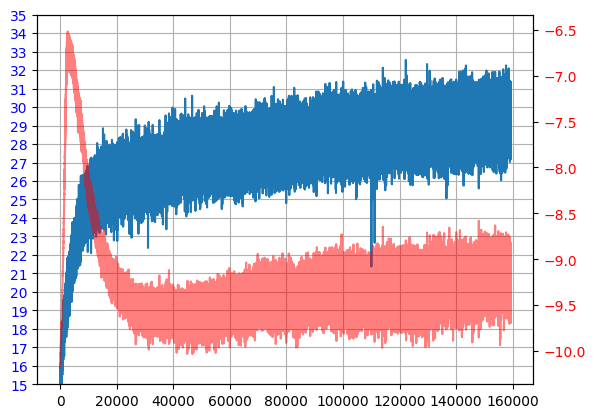

In [8]:
display(HTML(mb.main_bar.progress))
display(HTML(pb.progress))
fig, ax1 = plt.subplots()
ax1.plot(-10*np.array(losses)+6.02)
ax1.set_yticks(range(15,36))
ax1.set_ylim([15,35])
ax1.grid(True)
ax1.tick_params(axis='y', labelcolor='blue')
ax2 = ax1.twinx()
ax2.plot(-10*np.array(rate_losses), color='red', alpha=0.5)
ax2.tick_params(axis='y', labelcolor='red')
plt.show()

In [10]:
torch.save({
    'config': config,
    'state_dict': model.state_dict(),
    'em_state_dict': em.state_dict(),
}, '../../hf/autocodec/rgb_f16c48_em.pth')